In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_multitaper
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mne.preprocessing import ICA 
%matplotlib qt

In [36]:
raw = mne.io.read_raw_edf (
    './EEG_nback_task/Psychopy_choi_nback_2025-05-23T171537.165397_EPOCX_229017_2025.05.23T17.15.37+09.00.edf',
    preload=True,
)

Extracting EDF parameters from c:\Users\tlsdm\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\Psychopy_choi_nback_2025-05-23T171537.165397_EPOCX_229017_2025.05.23T17.15.37+09.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 26239  =      0.000 ...   204.992 secs...


In [37]:
eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [38]:
raw.pick_channels(eeg_channels)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | Psychopy_choi_nback_2025-05-23T171537.165397_EPOCX_229017_2025.05.23T17.15.37+09.00.edf, 14 x 26240 (205.0 s), ~2.8 MiB, data loaded>

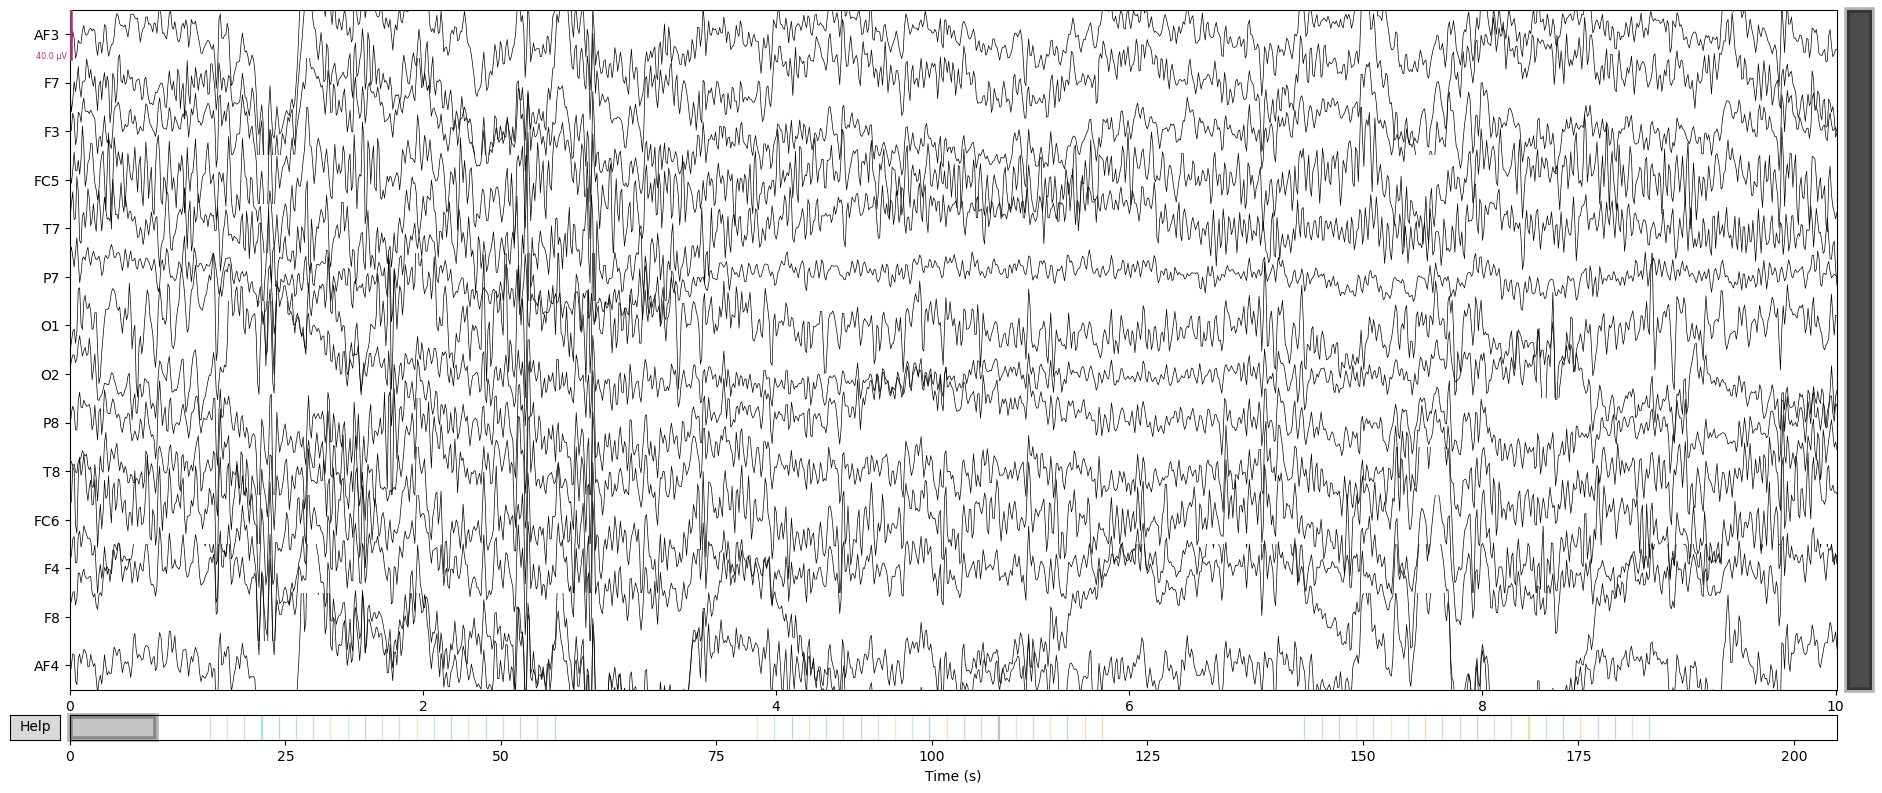

Channels marked as bad:
none
Channels marked as bad:
none


In [39]:
raw.plot()

In [31]:
raw.filter(l_freq=1, h_freq=40)
raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

<RawEDF | Psychopy_choi_nback_2025-05-23T165917.140799_EPOCX_229017_2025.05.23T16.59.17+09.00.edf, 14 x 28672 (224.0 s), ~3.1 MiB, data loaded>

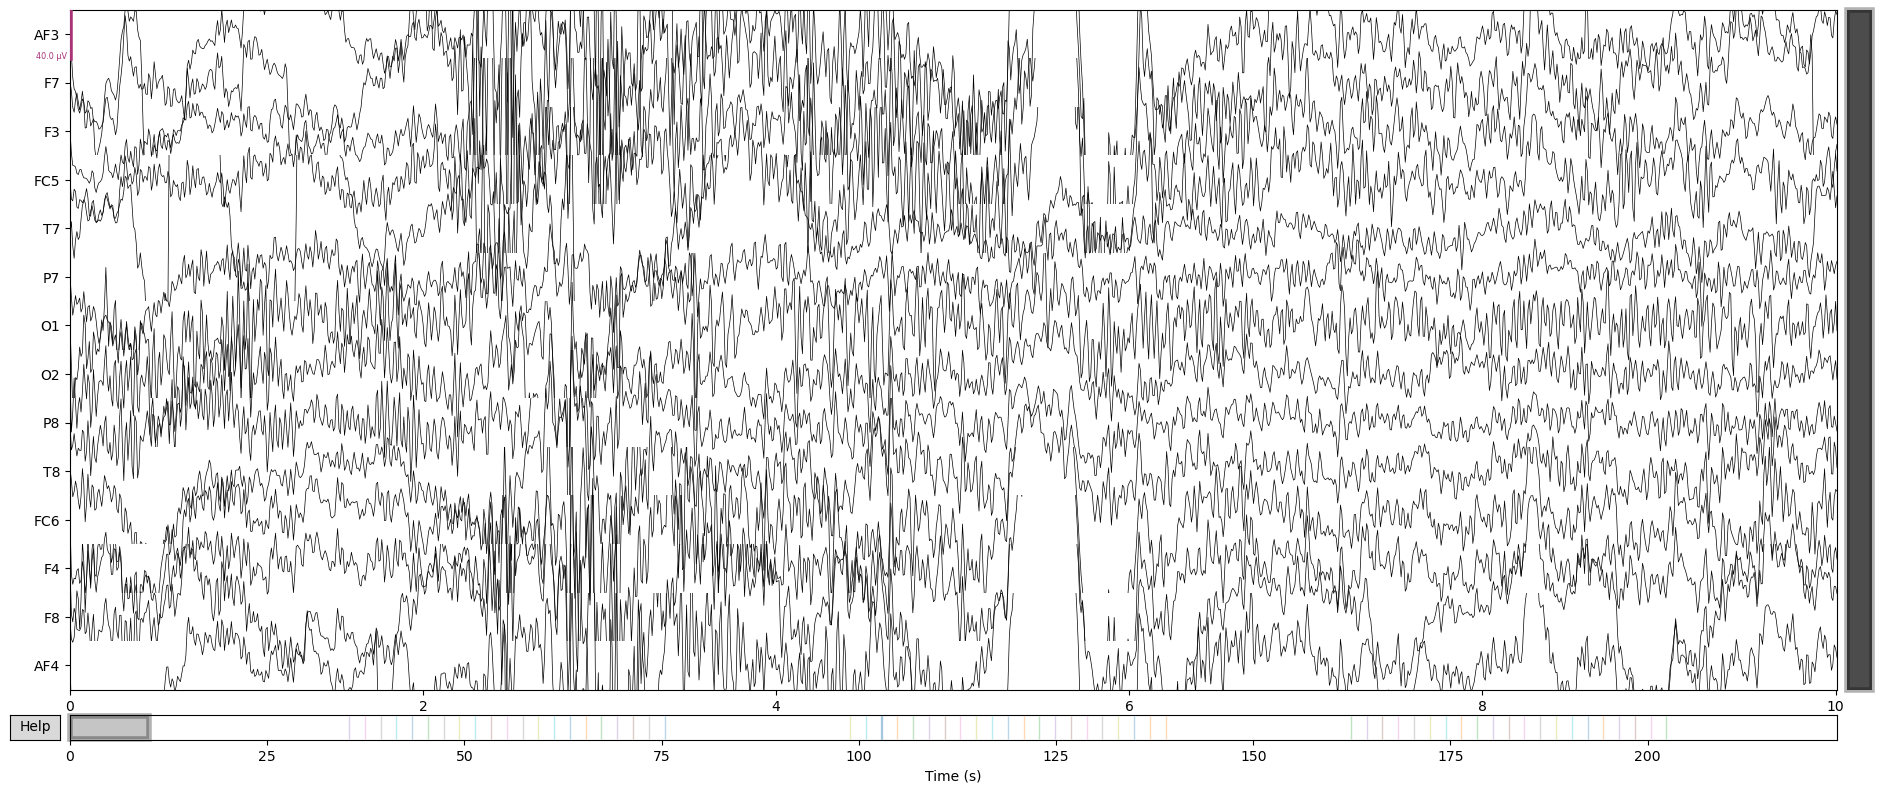

In [33]:
raw.plot()

In [40]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | Psychopy_choi_nback_2025-05-23T171537.165397_EPOCX_229017_2025.05.23T17.15.37+09.00.edf, 14 x 26240 (205.0 s), ~2.8 MiB, data loaded>

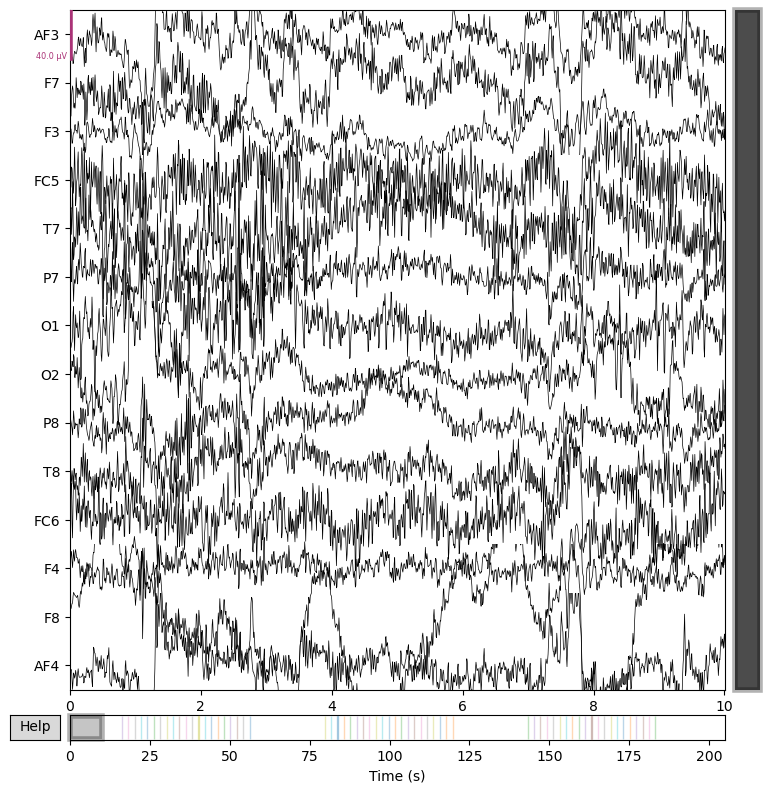

Channels marked as bad:
none


In [41]:
raw.plot()

In [44]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)
print("채널 위치 설정 완료:", raw.info['dig'] is not None)

채널 위치 설정 완료: True


In [46]:
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors(kind='3d', show_names=True)


In [45]:
from autoreject import AutoReject

# epochs 생성 
events = mne.make_fixed_length_events(raw, duration=3.0)
epochs = mne.Epochs(
    raw, events,
    tmin=0, tmax=3.0-1/raw.info['sfreq'],
    baseline=None,
    preload=True
)

# AutoReject으로 bad channel과 bad epoch 동시 처리 
ar = AutoReject(random_state=42)
epochs_clean = ar.fit_transform(epochs)

#결과 확인 
print(f"원본 epochs: {len(epochs)}")
print(f"정리된 epochs: {len(epochs_clean)}")


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 384 original time points ...
0 bad epochs dropped


c:\Users\tlsdm\.conda\envs\mne\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 14/14 [00:00<00:00,   56.26it/s]
100%|██████████| Computing thresholds ... : 14/14 [00:04<00:00,    3.19it/s]











100%|██████████| Repairing epochs : 68/68 [00:00<00:00,  379.94it/s]

















































100%|██████████| Repairing epochs : 68/68 [00:01<00:00,   65.72it/s]






















100%|██████████| Fold : 10/10 [00:00<00:00,   23.79it/s]















































100%|██████████| Repairing epochs : 68/68 [00:00<00:00,   68.55it/s]






















100%|██████████| Fold : 10/10 [00:00<00:00,   28.89it/s]















































100%|██████████| Repairing epochs : 68/68 [00:00<00:00,   70.63it/s]






100%|██████████| Fold : 10/10 [00:00<00:00,  202.27it/s]
100%|██████████| n_interp : 3/3 [00:03<00:00,    1.30s/it]






Estimated consensus=0.40 and n_interpolate=1



















































100%|██████████| Repairing epochs : 68/68 [00:01<00:00,   64.88it/s]

Dropped 10 epochs: 0, 4, 5, 19, 20, 21, 22, 25, 43, 45
원본 epochs: 68
정리된 epochs: 58


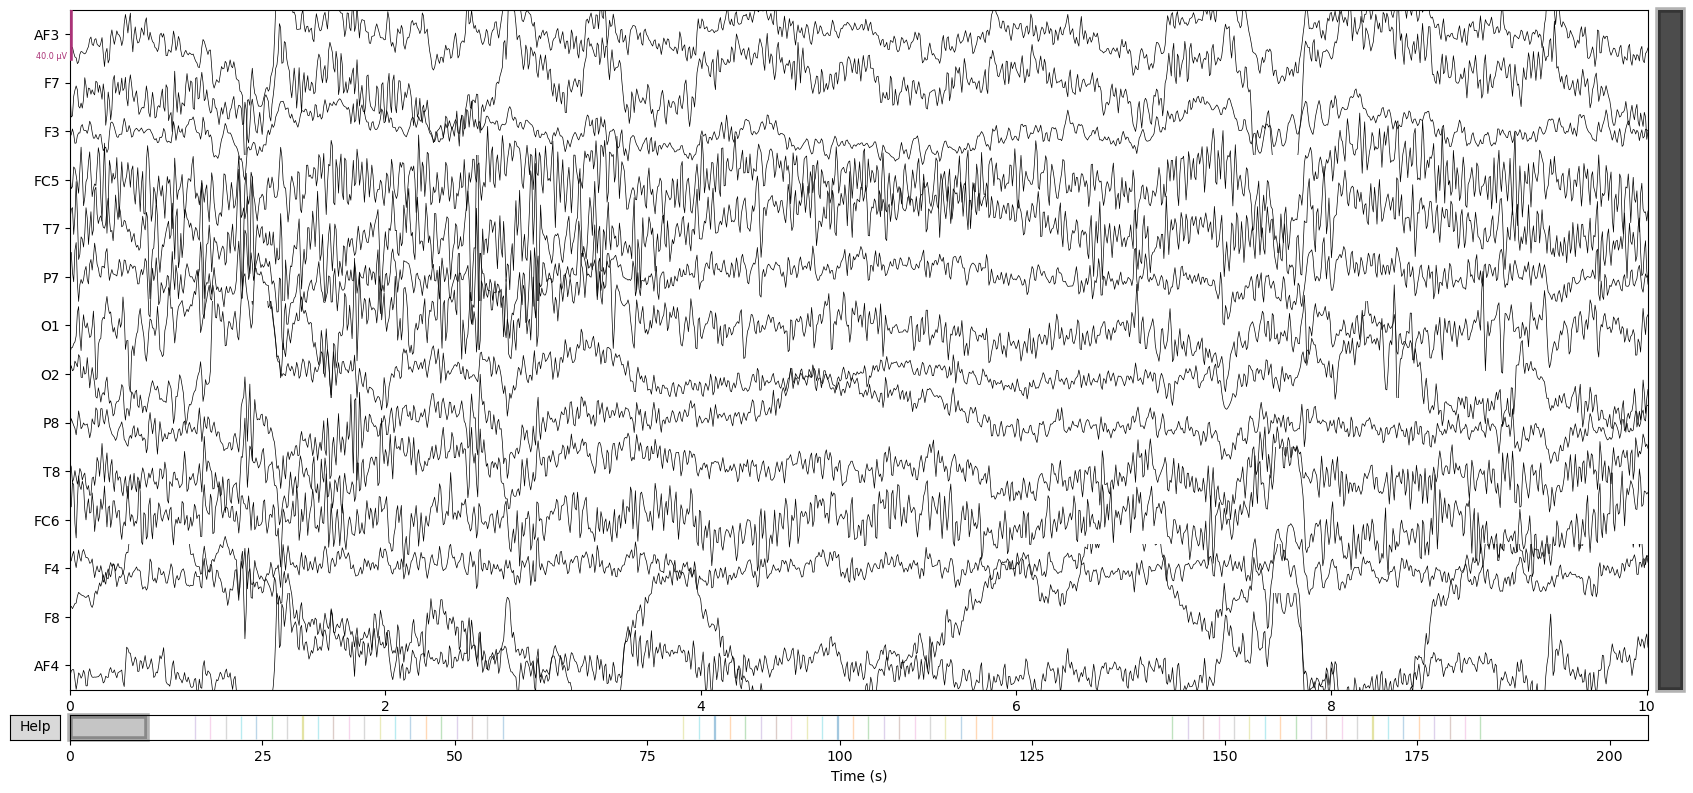

Channels marked as bad:
none


In [48]:
raw.plot()

In [28]:
def load_and_segment_nback_data(edf_file, marker_file):
    # EEG 데이터 로드
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    
    # Marker 정보 로드
    markers_df = pd.read_csv(marker_file)
    
    # Task 시작과 끝 시간 찾기
    task_starts = markers_df[markers_df['type'] == 'task_start']['latency'].values
    task_ends = markers_df[markers_df['type'] == 'task__end']['latency'].values
    
    # 데이터 세그먼트 저장을 위한 딕셔너리
    segments = {
        '0back': None,
        'rest': [],
        '2back': None,
        '3back': None
    }
    
    # 첫 번째 블록: 0-back
    zero_back_end_idx = np.where(task_starts < task_ends[0])[0][-1]
    segments['0back'] = raw.copy().crop(tmin=task_starts[0], tmax=task_ends[0])
    
    # 첫 번째 rest
    rest_start = task_ends[0]
    rest_end = task_starts[zero_back_end_idx + 1]
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    # 두 번째 블록: 2-back
    two_back_end_idx = np.where(task_starts < task_ends[1])[0][-1]
    segments['2back'] = raw.copy().crop(tmin=task_starts[zero_back_end_idx + 1], tmax=task_ends[1])
    
    # 두 번째 rest
    rest_start = task_ends[1]
    rest_end = task_starts[two_back_end_idx + 1]
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    # 세 번째 블록: 3-back
    three_back_end_idx = np.where(task_starts < task_ends[2])[0][-1]
    segments['3back'] = raw.copy().crop(tmin=task_starts[two_back_end_idx + 1], tmax=task_ends[2])
    
    # 세 번째 rest (3-back 이후)
    rest_start = task_ends[2]
    if len(task_starts) > three_back_end_idx + 1:
        rest_end = task_starts[three_back_end_idx + 1]
    else:
        rest_end = raw.times[-1]  # 데이터의 끝까지
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    return segments

# 사용 예시
edf_file = 'EEG_nback_task/Psychopy_taek_nback_2025-05-23T182917.139270_EPOCX_229017_2025.05.23T18.29.17+09.00.edf'
marker_file = 'EEG_nback_task/Psychopy_taek_nback_2025-05-23T182917.139270_EPOCX_229017_2025.05.23T18.29.17+09.00_intervalMarker.csv'
segments = load_and_segment_nback_data(edf_file, marker_file)

# 각 세그먼트 확인
for condition, data in segments.items():
    if condition == 'rest':
        print(f"\n{condition} 조건:")
        for i, rest_data in enumerate(data):
            print(f"세그먼트 {i+1}: {rest_data.times[0]:.2f}s - {rest_data.times[-1]:.2f}s")
    else:
        print(f"\n{condition} 조건:")
        if data is not None:
            print(f"시간 구간: {data.times[0]:.2f}s - {data.times[-1]:.2f}s")

Extracting EDF parameters from c:\Users\tlsdm\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\Psychopy_taek_nback_2025-05-23T182917.139270_EPOCX_229017_2025.05.23T18.29.17+09.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24703  =      0.000 ...   192.992 secs...

0back 조건:
시간 구간: 0.00s - 40.01s

rest 조건:
세그먼트 1: 0.00s - 23.48s
세그먼트 2: 0.00s - 23.48s
세그먼트 3: 0.00s - 21.70s

2back 조건:
시간 구간: 0.00s - 40.03s

3back 조건:
시간 구간: 0.00s - 40.01s


In [29]:

def get_nback_raw_data(edf_file, marker_file):
    from mne.io import RawArray
    
    # 기존 세그먼트 불러오기
    segments = load_and_segment_nback_data(edf_file, marker_file)
    
    # Task 데이터 저장 (0back, 2back, 3back)
    raw_0back = segments['0back']
    raw_2back = segments['2back']
    raw_3back = segments['3back']
    
    # Rest 데이터 각각 저장
    raw_rest_0back = segments['rest'][0]  # 0-back 이후의 rest
    raw_rest_2back = segments['rest'][1]  # 2-back 이후의 rest
    raw_rest_3back = segments['rest'][2]  # 3-back 이후의 rest
    
    return raw_0back, raw_2back, raw_3back, raw_rest_0back, raw_rest_2back, raw_rest_3back

# 사용 예시
edf_file = 'EEG_nback_task/Psychopy_choi_nback_2025-05-23T170605.561849_EPOCX_229017_2025.05.23T17.06.05+09.00.edf'
marker_file = 'EEG_nback_task/Psychopy_choi_nback_2025-05-23T170605.561849_EPOCX_229017_2025.05.23T17.06.05+09.00_intervalMarker.csv'

# 데이터를 변수에 저장
raw_0back, raw_2back, raw_3back, raw_rest_0back, raw_rest_2back, raw_rest_3back = get_nback_raw_data(edf_file, marker_file)

# 데이터 확인
print("\n각 조건 데이터 정보:")
for name, raw in [
    ('0-back', raw_0back), ('rest after 0-back', raw_rest_0back),
    ('2-back', raw_2back), ('rest after 2-back', raw_rest_2back),
    ('3-back', raw_3back), ('rest after 3-back', raw_rest_3back)
]:
    print(f"\n{name} 데이터:")
    print(f"시간 길이: {raw.times[-1]:.2f}초")
    print(f"채널 수: {len(raw.ch_names)}")


Extracting EDF parameters from c:\Users\tlsdm\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\Psychopy_choi_nback_2025-05-23T170605.561849_EPOCX_229017_2025.05.23T17.06.05+09.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24831  =      0.000 ...   193.992 secs...

각 조건 데이터 정보:

0-back 데이터:
시간 길이: 40.01초
채널 수: 55

rest after 0-back 데이터:
시간 길이: 23.48초
채널 수: 55

2-back 데이터:
시간 길이: 40.03초
채널 수: 55

rest after 2-back 데이터:
시간 길이: 23.49초
채널 수: 55

3-back 데이터:
시간 길이: 39.99초
채널 수: 55

rest after 3-back 데이터:
시간 길이: 22.06초
채널 수: 55


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels):
    """
    PSD를 이용하여 ERDS 계산
    
    Parameters:
    -----------
    task_raw : Raw task 데이터
    rest_raw : Raw rest 데이터
    fmin, fmax : 관심 주파수 대역
    channels : 분석할 채널 리스트
    
    Returns:
    --------
    erds : ERDS 값 (퍼센트)
    """
    # 채널 선택
    task_data = task_raw.copy().pick(channels)
    rest_data = rest_raw.copy().pick(channels)
    
    # PSD 계산
    task_psd = task_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
    rest_psd = rest_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
    
    # 관심 주파수 대역의 평균 파워 추출
    freq_mask = (task_psd.freqs >= fmin) & (task_psd.freqs <= fmax)
    task_power = task_psd.get_data()[:, freq_mask].mean(axis=1)
    rest_power = rest_psd.get_data()[:, freq_mask].mean(axis=1)
    
    # ERDS 계산: (Rest - Task) / Rest * 100
    erds = (rest_power - task_power) / rest_power * 100
    
    return erds

# 주파수 대역 정의
freq_bands = {
    'theta': (4, 7),
    'alpha': (8, 13)
}

# 채널 그룹 정의
channel_groups = {
    'theta': ['F3', 'F4'],  # 전두엽 채널
    'alpha': ['P7', 'P8']   # 두정엽 채널
}

# 결과를 저장할 딕셔너리 초기화
results = {}
for band in freq_bands.keys():
    results[band] = {}
    for channel in channel_groups[band]:
        results[band][channel] = []

# 각 조건에 대해 ERDS 계산
conditions = [
    (raw_0back, raw_rest_0back, '0-back'),
    (raw_2back, raw_rest_2back, '2-back'),
    (raw_3back, raw_rest_3back, '3-back')
]

conditions_list = ['0-back', '2-back', '3-back']

# 결과 계산 및 저장
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n=== {band_name.capitalize()} 밴드 ({fmin}-{fmax} Hz) ===")
    channels = channel_groups[band_name]
    
    for task_raw, rest_raw, condition in conditions:
        erds = calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels)
        
        for ch_idx, channel in enumerate(channels):
            results[band_name][channel].append(erds[ch_idx])
            print(f"{condition}, {channel}: {erds[ch_idx]:.2f}%")

# 시각화
plt.figure(figsize=(15, 10))

# Theta와 Alpha 밴드를 위한 서브플롯 생성
for i, band in enumerate(['theta', 'alpha']):
    plt.subplot(2, 1, i+1)
    
    channels = channel_groups[band]
    x = np.arange(len(conditions_list))
    width = 0.35
    
    # 각 채널에 대한 막대 그래프
    for j, channel in enumerate(channels):
        plt.bar(x + j*width, results[band][channel], width, 
                label=channel, alpha=0.8)
    
    plt.xlabel('Condition')
    plt.ylabel('ERDS (%)')
    plt.title(f'{band.capitalize()} Band ERDS')
    plt.xticks(x + width/2, conditions_list)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Theta 밴드 (4-7 Hz) ===
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
0-back, F3: 38.97%
0-back, F4: 52.86%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
2-back, F3: 20.61%
2-back, F4: 24.35%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
3-back, F3: 9.91%
3-back, F4: 4.16%

=== Alpha 밴드 (8-13 Hz) ===
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
0-back, P7: 47.00%
0-back, P8: 58.32%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
2-back, P7: 12.08%
2-back, P8: -11.41%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
3-back, P7: 49.27%
3-back, P8: 22.75%


In [51]:
ica = mne.preprocessing.ICA(n_components=None)
ica.fit(raw)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 14 components
Fitting ICA took 0.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,30 iterations on raw data (26240 samples)
ICA components,14
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


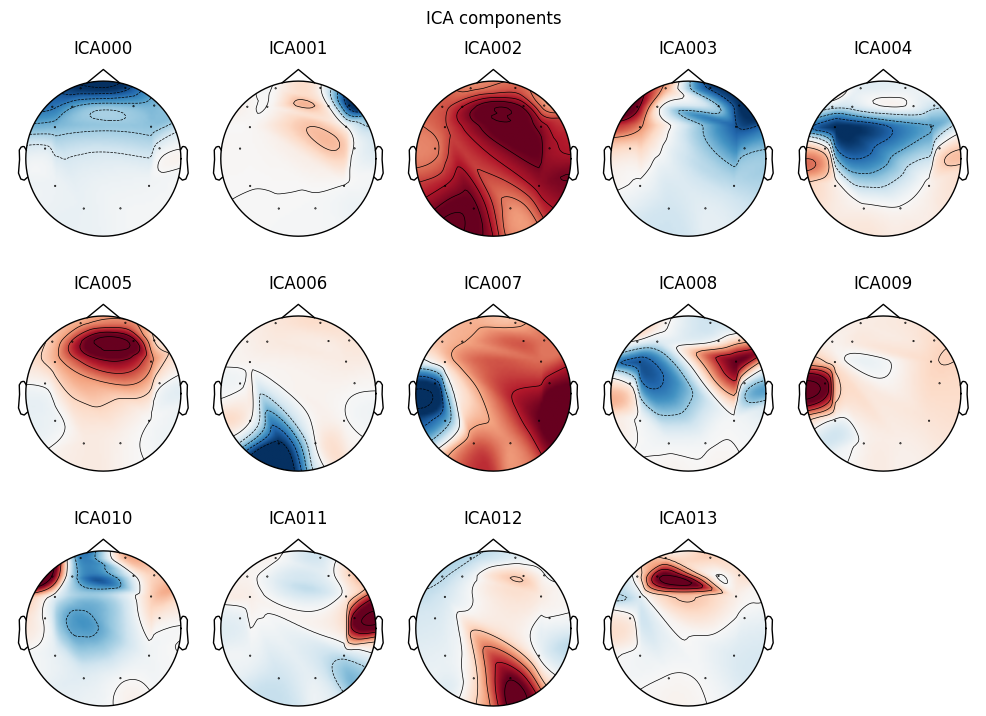

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [52]:
ica.plot_components()  # 이상한 컴포넌트 시각적으로 확인

In [ ]:
ica.exclude = [2, 3]  # ICA002, ICA003 제거 (안구 artifact)
ica.apply(raw)        # 원본 데이터에서 제거 적용